In [163]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits,ascii
import pandas as pd
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u
import cmasher as cmr

In [266]:
sample = pd.read_csv("~/Documents/OneDrive - UNSW/MAGPI_csv/MAGPI_kinemetry_sample.csv")
#sample = sample[sample["v_asym_s"]/sample["v_asym_s_err"]>3]
prospect = pd.read_csv("~/Documents/OneDrive - UNSW/MAGPI_csv/MAGPI_ProSpectCat_v0.1.csv")
bpt = pd.read_csv("~/Documents/OneDrive - UNSW/MAGPI_csv/MAGPI_kinemetry_sample_BPT.csv")
ssp = pd.read_csv("~/Documents/OneDrive - UNSW/MAGPI_csv/MAGPI_ApertureSpectra_StellarPops_V1.0_SPV.csv")
prospect = prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]
bpt = bpt[bpt['MAGPIID'].isin(sample["MAGPIID"])]
ssp = ssp[ssp["MAGPIID"].isin(sample["MAGPIID"])]

In [277]:
ssp

,MAGPIID,has_ppxf_fit_0.5re,quick_SN_0.5re,ppxf_SN_0.5re,logage_MW_0.5re,metallicity_MW_0.5re,alpha_MW_0.5re,logage_LW_0.5re,metallicity_LW_0.5re,alpha_LW_0.5re,...,logage_LW_3arcsec,metallicity_LW_3arcsec,alpha_LW_3arcsec,ppxf_chi2_3arcsec,sigma_3arcsec,fraction_last_Gyr_MW_3arcsec,fraction_less_solar_MW_3arcsec,fraction_last_Gyr_LW_3arcsec,fraction_less_solar_LW_3arcsec,QOP_3arcsec
50,1201197192,True,95.191920,48.679634,10.064669,0.335773,0.032144,10.004246,0.216751,0.083176,...,10.015382,0.173174,0.105001,4.783920,226.658462,0.000308,0.094116,0.005175,0.216755,[4]
51,1201197199,True,120.716125,51.171571,10.096772,0.366714,0.015724,10.002775,0.287407,0.056979,...,10.023303,0.222530,0.086267,6.986726,289.132990,0.004401,0.067315,0.050104,0.157329,[4]
68,1201252223,True,17.995996,15.602648,9.685073,-0.174052,0.041263,9.483545,-0.080125,0.124074,...,9.899129,-0.248066,0.222856,1.752729,120.419254,0.020585,0.766963,0.176091,0.710130,[4]
87,1201302222,True,9.606786,8.189251,9.631752,-1.013311,0.031771,9.191170,-0.897170,0.115373,...,8.878485,-1.065152,0.273234,1.634724,56.421526,0.384400,0.693251,0.683084,0.548746,[4]
138,1202197197,True,102.622574,37.602139,9.719202,0.087509,0.197620,9.274061,-0.168836,0.082740,...,9.104819,-0.206395,0.082697,8.247158,139.292890,0.196719,0.081766,0.659412,0.358249,[4]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3817,2308198197,True,189.680660,67.113824,9.891442,0.238660,0.013295,9.552374,0.150328,0.036228,...,9.538733,0.028362,0.052893,8.725327,242.485984,0.052111,0.044773,0.255883,0.149248,[4]
3848,2308295194,True,36.624890,22.690921,9.696853,-0.004507,0.195634,9.039139,-0.316626,0.105728,...,9.205060,-0.282732,0.125818,2.118445,78.371254,0.155838,0.646945,0.589482,0.459387,[4]
3915,2310167176,True,118.714640,3.267356,10.064948,-2.270000,0.397602,9.604956,-2.270000,0.338230,...,9.610869,-1.445896,0.330433,342.415384,207.405731,0.004155,0.393153,0.200546,0.691347,[4]
3921,2310199196,True,167.127080,61.883228,10.113711,0.262424,0.013194,9.930447,0.145031,0.071113,...,9.859269,0.051253,0.095283,4.634008,218.265837,0.015056,0.044706,0.182438,0.132549,[4]


/var/folders/hn/phg07l9934x4013mnrp122c40000gn/T/ipykernel_20776/4287104189.py:7: RuntimeWarning: divide by zero encountered in log10
  s = np.log10(s)


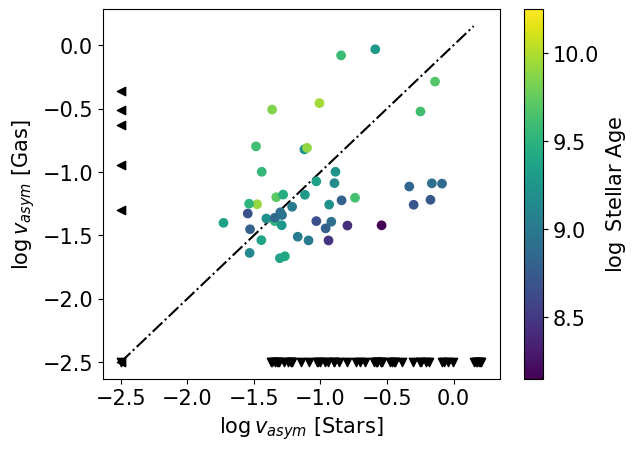

In [291]:
s = sample["v_asym_s"].to_numpy()
s[np.isnan(s)]=10**(-2.5)
g = sample["v_asym_g"].to_numpy()
g[np.isnan(g)]=10**(-2.5)
g = np.log10(g)
#gg = g[g>-2.5]
s = np.log10(s)
#ss = s[s>-2.5]
x = np.ones(6)
x[x==1]=-2.5
y = np.ones(53)
y[y==1]=-2.5
fig,ax = plt.subplots()
p=ax.scatter(s[(g>-2.5) & (s>-2.5)],g[(g>-2.5) & (s>-2.5)],
             c=ssp["logage_LW_2re"].to_numpy()[(g>-2.5) & (s>-2.5)],zorder=2,vmin=8.15,vmax=10.25)
ax.scatter(x,g[s==-2.5],marker="<",c="k")
ax.scatter(s[g==-2.5],y,marker="v",c="k")
ax.plot(np.linspace(-2.5,0.15),np.linspace(-2.5,0.15),color="k",ls="dashdot",zorder=1)
plt.colorbar(p,ax=ax,label=r"$\log$ Stellar Age")
ax.set_xlabel(r"$\log v_{asym}$ [Stars]")
ax.set_ylabel(r"$\log v_{asym}$ [Gas]")
plt.show()

In [264]:
print(len(g[s==-2.5]))
print(len(s[g==-2.5]))

6
53


In [258]:
sample = pd.read_csv("~/Documents/OneDrive - UNSW/MAGPI_csv/kinemetry_sample_M2.csv")
sample = sample[sample["v_asym_15re_err"]<0.1]
bpt = pd.read_csv("~/Documents/OneDrive - UNSW/MAGPI_csv/MAGPI_kinemetry_sample_BPT.csv")
bpt = bpt[bpt['MAGPIID'].isin(sample["MAGPIID"])]
galfit = pd.read_csv("~/Documents/OneDrive - UNSW/MAGPI_csv/MAGPI_GalfitSersicCat_v0.1.csv")
galfit = galfit[galfit['MAGPIID'].isin(sample['MAGPIID'])]

In [259]:
x = galfit["re"].to_numpy()
y = bpt["re, arcsec"].to_numpy()
p = sample['MAGPIID'].to_numpy()

In [262]:
check=[]
for i,j,k in zip(x,y,p):
    # if i>0.7 and j>0.7:
    #     print("Meets Criteria")
    # if i>0.7 and j<0.7:
    #     print("Meets Galfit")
    if i<0.7 and j>0.7:
        print(f"{k:.0f}, g:{i:.2f}'', p:{j:.2f}''")
        print("Meets only profit")
        check.append(k)

1201302222, g:0.64'', p:0.81''
Meets only profit
1205196165, g:0.63'', p:0.91''
Meets only profit
1206322202, g:0.53'', p:0.90''
Meets only profit
2301288271, g:0.58'', p:1.04''
Meets only profit
2308186140, g:0.69'', p:0.95''
Meets only profit
2308295194, g:0.64'', p:0.81''
Meets only profit


In [261]:
sample[sample["MAGPIID"].isin(check)]

,MAGPIID,v_asym_05re,v_asym_05re_err,v_asym_15re,v_asym_15re_err,v_asym_tot,v_asym_tot_err,k51_05re,k51_05re_err,k51_15re,k51_15re_err,k51_tot,k51_tot_err,SNR_05re,SNR_15re
0,1201302222,0.062283,0.017017,0.067625,0.011522,0.073141,0.012732,0.027058,0.016308,0.031614,0.015903,0.044128,0.014668,46.392823,25.072726
7,1205196165,0.020055,0.007543,0.070926,0.010644,0.034741,0.010067,0.014821,0.008431,0.100639,0.023426,0.036714,0.010873,35.349898,9.912172
11,1206322202,0.036912,0.008226,0.074670,0.015343,0.046692,0.004518,0.015593,0.007184,0.050457,0.031181,0.018641,0.006271,57.305509,7.595860
40,2301288271,0.025894,0.009557,0.307238,0.053715,0.057679,0.008131,0.009752,0.006555,0.383450,0.101522,0.048185,0.008434,44.864082,3.517074
48,2308186140,0.064208,0.014636,0.084301,0.009141,0.080719,0.008479,0.023051,0.013237,0.040338,0.021150,0.036828,0.010317,59.065993,21.484629
50,2308295194,0.060662,0.018115,0.146054,0.026920,0.088827,0.016580,0.028496,0.015401,0.118155,0.045471,0.052293,0.018216,18.878627,4.085278
